#### Last Modified: July 21st, 2022 (Opal). 

## sOpInf on Three-Dimensional Steady MHD Solar Wind Radial Speed

In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM-Revised


In [2]:
import numpy as np
import scipy
import scipy.linalg as la
from scipy import signal
import scipy.sparse as sparse
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
import time
import astropy.units as u
import cv2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
# use LaTeX fonts in the plot
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

## Import MHD solar wind radial velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
print(model.variables)
# get back to original directory
os.chdir(curr_dir)

['bp', 'br', 'bt', 'p', 'rho', 't', 'vp', 'vr', 'vt']


In [5]:
# read in MHD velocity results. 
vr_model = model['vr']

In [6]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
n = len(p)
# delta phi
dp = p[1:] - p[:-1]
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# change in r
dr = r[1:] - r[:-1]
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

# save radial velocity 
V = np.array(f)

In [8]:
PlotSlices = False
if PlotSlices == True:
    for ii in np.arange(len(r)):
        fig, ax = plt.subplots(figsize=(11, 5))
        im = ax.imshow(f[:, :, ii].T,
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                    vmin = 300, vmax = 700, cmap="viridis", aspect="auto", origin="lower")

        ax.set_title("$V_{r}$, r = " + str(round(r[ii].to(u.AU).value, 2)) + " AU")
        ax.set_yticks([-90, -45, 0, 45, 90])
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xlabel("Carrington Longitude (Deg.)")
        ax.set_ylabel("Latitude (Deg.)")
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('km/s', rotation=90)
        file_name = "figs/Animation/fig_" + str(ii) + ".png"
        fig.savefig(file_name, dpi=500)

In [9]:
SaveVid = False

if SaveVid:
    # choose codec according to format needed
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter("sw_vid.mov", fourcc, 30, (5500, 2500))
    # loop over save images. 
    for j in range(len(r)):
        file_name = "figs/Animation/fig_" + str(j) + ".png"
        img = cv2.imread(file_name)
        video.write(img)
    cv2.destroyAllWindows()
    video.release()

### Background: Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [10]:
def plot_slices_fig(data, title="MHD CR2210", figsave="figs/mhd_2D_slices.png", vmin=300, vmax=700, cbar_label="km/s"):
    fig = plt.figure(figsize=(10,12))
    for id_subplot, snapshot in enumerate(np.append(np.arange(0, len(r), 30), len(r)-1), start=1):
        plt.subplot(4, 2, id_subplot)
        im = plt.imshow(data[:, :, snapshot].T,  vmin=vmin, vmax=vmax, 
                        extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[-1]*180/np.pi, t[0]*180/np.pi],   
                     cmap="plasma", aspect="auto")
        plt.title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
        plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
        plt.yticks([90, 45, 0, -45, -90])
        plt.xticks([360, 270, 180, 90, 0])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.99, 0.3, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)

    _ = cbar_ax.set_ylabel('km/s', rotation=90)


    fig.suptitle(title)
    plt.tight_layout()

    fig.savefig(figsave, dpi=300, bbox_inches='tight')

In [11]:
print(np.argmin(np.abs(t - np.pi/6)))
print(np.argmin(np.abs(t + np.pi/6)))

73
37


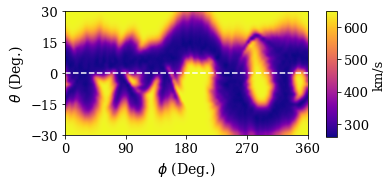

In [12]:
    fig = plt.figure(figsize=(5,5))
    for id_subplot, snapshot in enumerate(np.arange(1), start=1):
        plt.subplot(2, 1, id_subplot)
        im = plt.imshow(V[:, 36:74, 0].T,  
                        extent=[p[0]*180/np.pi, p[-1]*180/np.pi, -30, 30],   
                     cmap="plasma", aspect="auto", origin="lower", interpolation="spline16")
        #plt.title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
        plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
        plt.yticks([30, 15,  0, -15, -30])
        plt.xticks([360, 270, 180, 90, 0])
        plt.plot(p*180/np.pi, np.zeros(len(p)), c="white", ls="--")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.53, 0.03, 0.35])
    fig.colorbar(im, cax=cbar_ax)

    _ = cbar_ax.set_ylabel('km/s', rotation=90)


    #fig.suptitle(title)
    #plt.tight_layout()

plt.savefig("figs/cr2210_30rs_slice.png", dpi=500, bbox_inches='tight')

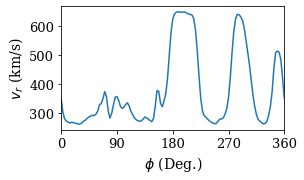

In [13]:
    fig = plt.figure(figsize=(4,5))
    for id_subplot, snapshot in enumerate(np.arange(1), start=1):
        plt.subplot(2, 1, id_subplot)
        plt.plot(p*180/np.pi, V[:, 55, 0].T)
        plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        plt.ylabel(r"$v_{r}$ (km/s)", fontsize=14)
        plt.xticks([360, 270, 180, 90, 0])
        plt.xlim(0, 360)
        plt.yticks([300, 400, 500, 600])

    #fig.suptitle(title)
    #plt.tight_layout()

plt.savefig("figs/cr2210_30rs_equator.png", dpi=500, bbox_inches='tight')

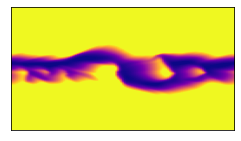

In [14]:
    fig = plt.figure(figsize=(4,5))
    for id_subplot, snapshot in enumerate(np.arange(1), start=1):
        plt.subplot(2, 1, id_subplot)
        im = plt.imshow(V[:, :, 130].T,  vmin=300, vmax=700, 
                        extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                     cmap="plasma", aspect="auto", origin="lower")
        #plt.title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
        #plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        #plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
        plt.yticks([])
        plt.xticks([])

    #fig.suptitle(title)
    #plt.tight_layout()

plt.savefig("snapshot3", dpi=300, bbox_inches='tight')

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_8750/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


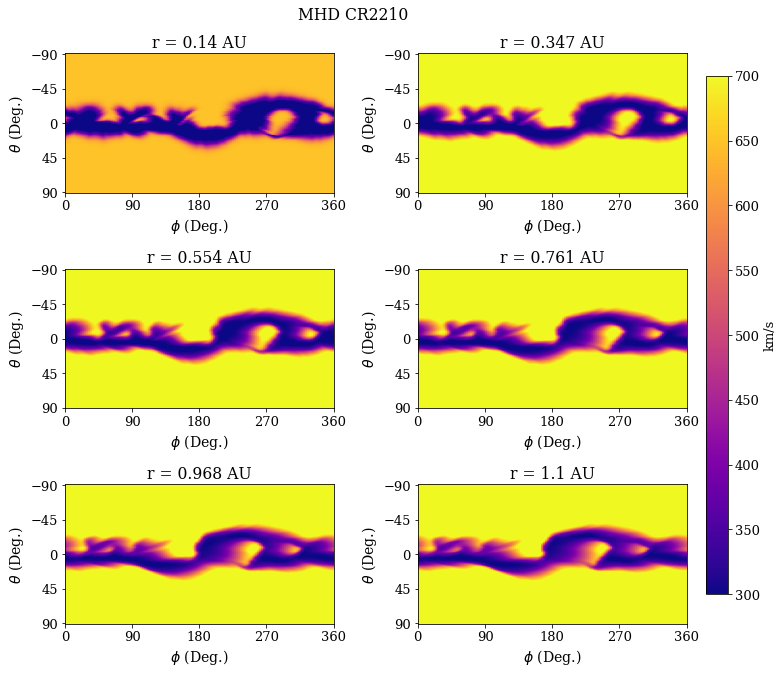

In [15]:
plot_slices_fig(data=f, title="MHD CR2210", figsave="figs/CR" + str(cr) +"/mhd_2d_slices.png")

In [16]:
def periodic_corr_2d(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return scipy.signal.correlate2d(x, np.concatenate((y[1:, :], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [17]:
v1 = V[:, :, 0]

shift_vec = [0]

for ii in range(1, len(r)):
    v2 = V[:, :, ii]
    
    corr = periodic_corr_2d(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    
    shift_vec.append(p[np.argmax(corr)]*180/np.pi)

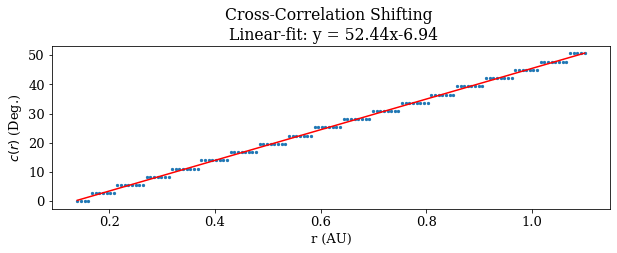

In [18]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), shift_vec, s=5)
m, b = np.polyfit(r[:int(0.7*len(r))].to(u.AU).value, shift_vec[:int(0.7*len(r))], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")

_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: y = " + str(round(m, 2)) + "x" + str(round(b, 2)))

In [19]:
def shift_function(r, m, b):
    return m * r + b

In [20]:
def interp_fun(p_shifted, p, t, v):
    # interpolator. 
    my_interpolating_function = RegularGridInterpolator((p, t), v)
    # create new mesh grid. 
    points = np.meshgrid(p_shifted, t)
    # flatten the mesh grid points to align with input for RegularGridInterp function.
    flat = np.array([m.flatten() for m in points])
    # pass to the interp function.
    out_array = my_interpolating_function(flat.T)
    # reshape back to original grid. 
    return out_array.reshape(*points[0].shape)

In [21]:
# initialize the data matrix. 
V_new = np.zeros((len(p), len(t), len(r)))

# initial conditon. 
V_new[:, :, 0] = V[:, :, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
    # define the new shifted coordinate.
    x_new = (p*180/np.pi - shift) % (360)
    # interpolate over the shifted coordinate
    V_new[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=V[:, :, jj]).T

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_8750/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


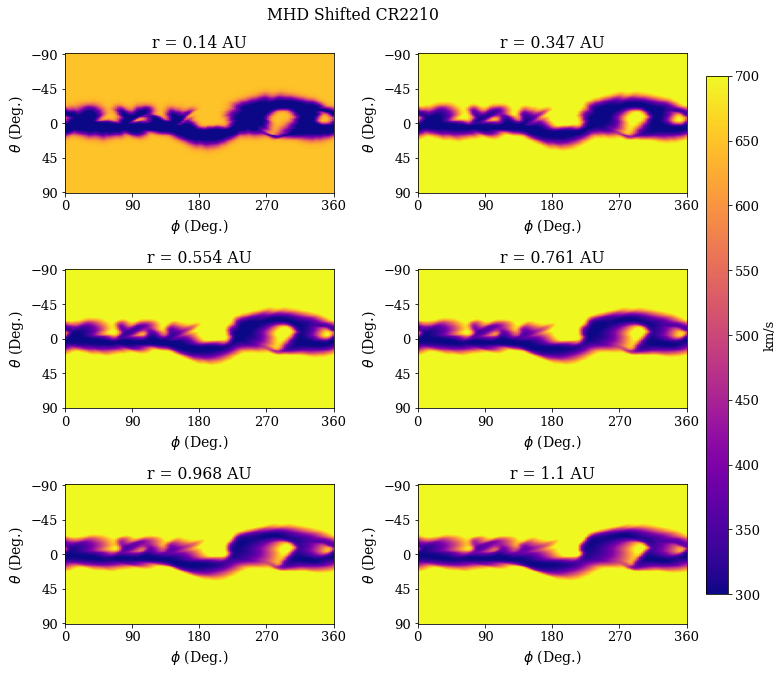

In [22]:
plot_slices_fig(data=V_new, title="MHD Shifted CR2210", figsave="figs/CR" + str(cr) + "/mhd_2D_shifted_slices.png")

## Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [23]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [24]:
X = V_new

In [25]:
V_new.shape

(129, 111, 140)

In [26]:
X_train = V_new[:, :, :l]
X_test = V_new[:, :, l:]

In [27]:
r_train = r[:l]
r_test = r[l:]

In [28]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 111, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 111, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Using the ROM Operator Inference Package

### Step 1: Choosing the Reduced-model Dimension
A simple choice for $r$ is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [29]:
def flatten(X):
    return X.reshape((len(p)*len(t), -1))
    

def undo_flatten(X):
    return X.reshape(len(p), len(t), -1)

In [30]:
svdvals = la.svdvals(flatten(X_train))
svdvals_prev = la.svdvals(flatten(V[:, :, :l]))

In [31]:
# Calculate the cumulative energy.
thresh = .995
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 2
r (Eularian coordinates)= 8


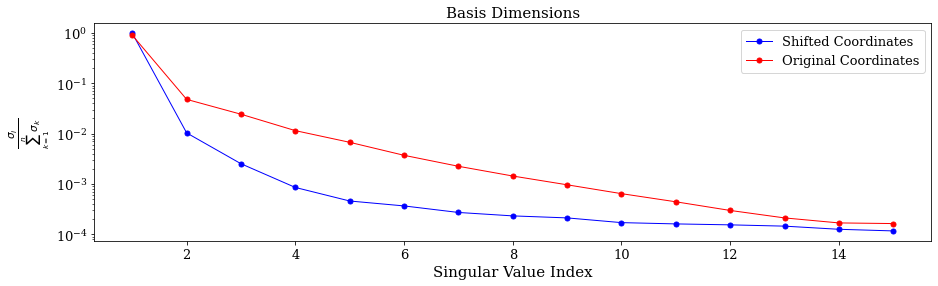

In [32]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, 16), svdvals[:15]/ np.sum(svdvals), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, 16), svdvals_prev[:15]/ np.sum(svdvals_prev), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")

plt.yscale("log")
plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}}$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

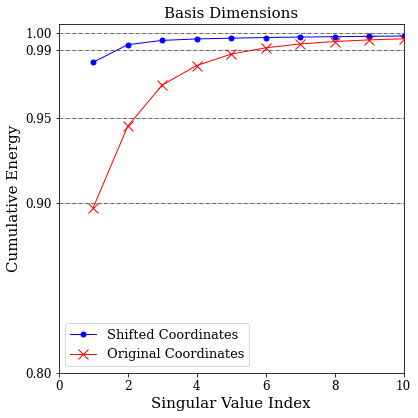

In [33]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(6, 6))

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals_prev.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
#ax.vlines(rank, 0, thresh, color="blue", linewidth=.6, linestyle="-.")
#ax.vlines(rank_prev, 0, thresh, color="red", linewidth=.6, linestyle="-.")


# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()     
plt.savefig("figs/CR" + cr + "/singular_value_decay.png", pad_inches=1)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [34]:
Vr, _ = roi.pre.pod_basis(flatten(X_train), 9, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (14319, 9)


In [35]:
undo_flatten(Vr).shape

(129, 111, 9)

To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

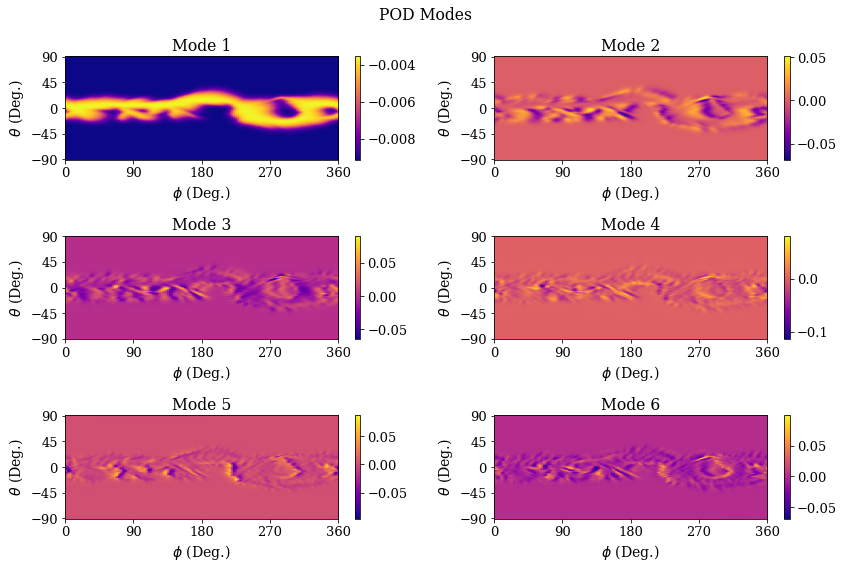

In [36]:
fig = plt.figure(figsize=(12,10))
for id_subplot, snapshot in enumerate(np.arange(0, 6, 1), start=1):
    plt.subplot(4, 2, id_subplot)
    im = plt.imshow(undo_flatten(Vr)[:, :, snapshot].T, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")
    fig.colorbar(im)
    plt.title("Mode " + str(id_subplot))
    plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
    plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
    plt.yticks([-90, -45, 0, 45, 90])
    plt.xticks([360, 270, 180, 90, 0])
fig.suptitle("POD Modes")
plt.tight_layout()

fig.savefig("figs/POD_Modes.png", dpi=300, bbox_inches='tight')

In [37]:
roi.pre.projection_error(flatten(X_train), Vr)

0.00044379196347729666

In [38]:
flatten(X_train).shape

(14319, 98)

## Model Form (Linear) $\frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t)$

we seek a reduced model of the form 
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$

but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Esentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind proton velocity at several heliocentric distances. 


In [39]:
X_ = Vr.T @ flatten(X_train)                                  # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, (r[1]-r[0]).value, order = 6) # Estimate the projected time derivatives.

In [40]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


In [41]:
model.fit(Vr, flatten(X_train), Xdot_, P=1E2)

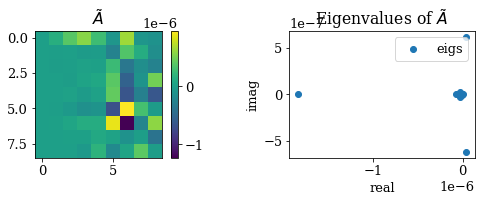

In [42]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
pos = ax[0].imshow(model.A_)
cbar = fig.colorbar(pos, ax=ax[0])
_ = ax[0].set_title(r"$\tilde A$")

# eigendecomposition of A. 
eigA, eigvecA = np.linalg.eig(model.A_)

_ = ax[1].scatter(eigA.real, eigA.imag, label="eigs")
_ = ax[1].set_xlabel("real")
_ = ax[1].set_ylabel("imag")
_ = ax[1].set_title("Eigenvalues of " + r"$\tilde A$")
_ = plt.legend()
_ = plt.tight_layout()

### Simulating the Reduced Model
Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [43]:
X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF")
X_ROM.shape

(14319, 140)

In [44]:
X_ROM = undo_flatten(X_ROM)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_8750/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


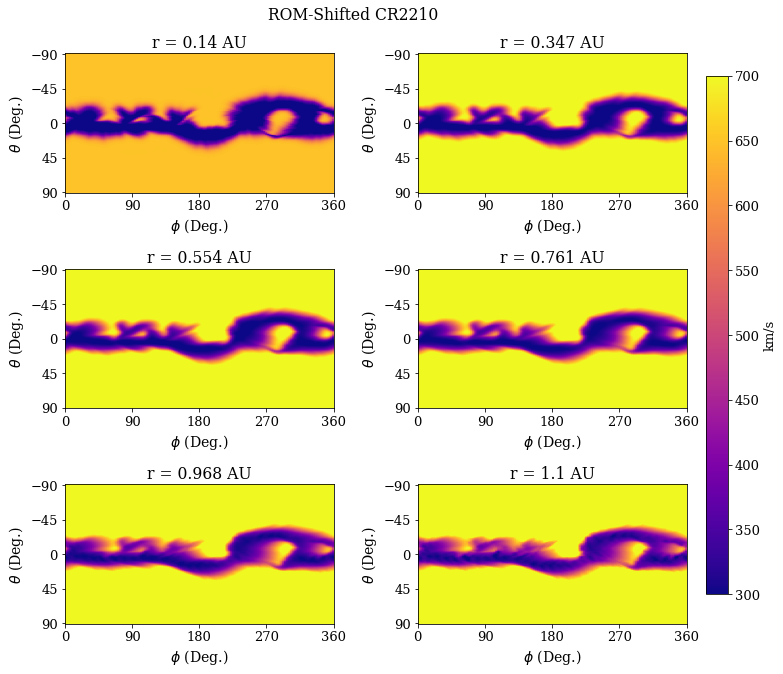

In [45]:
plot_slices_fig(X_ROM, title="ROM-Shifted CR" + cr, figsave="figs/CR" + cr + "/A/mhd_2D_XROM_shifted_slices.png")

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

In [46]:
def convert_from_x_to_v(X_ROM):
    # intialize the returned matrix. 
    V_ROM = np.zeros(X_ROM.shape)
    # initial condition
    V_ROM[:,:, 0] = X_ROM[:,:, 0]
    # iterate over all r slices. 
    for jj in range(1, len(r)):
        # compute shift from the linear fit above. 
        shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
        # define the new shifted coordinate.
        x_new = (p*180/np.pi + shift) % (360)
        # interpolate over the shifted coordinate
        V_ROM[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=X_ROM[:, :, jj]).T
    return V_ROM

In [47]:
V_ROM = convert_from_x_to_v(X_ROM)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_8750/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


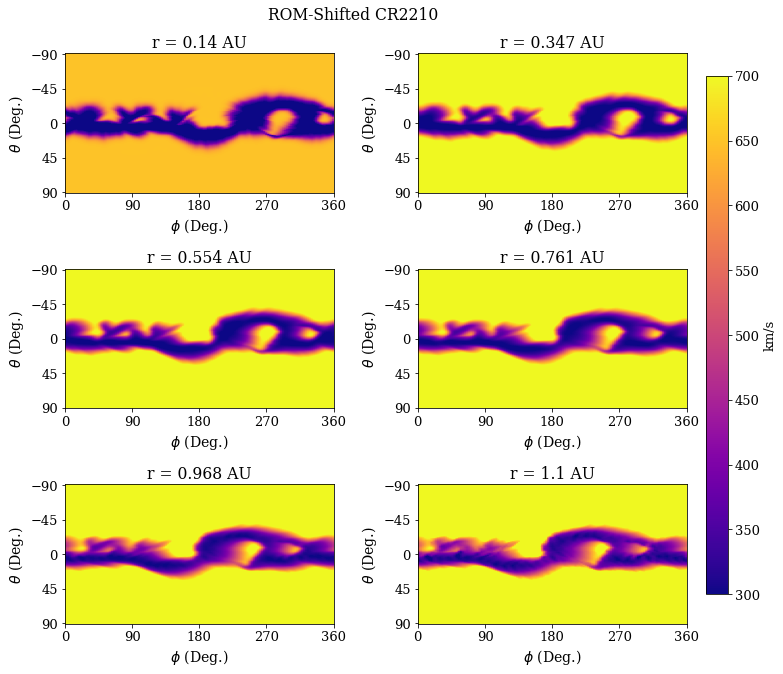

In [48]:
plot_slices_fig(V_ROM, title="ROM-Shifted CR" + cr, figsave="figs/CR" + cr + "/A/mhd_2D_VROM_slices.png")

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_8750/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


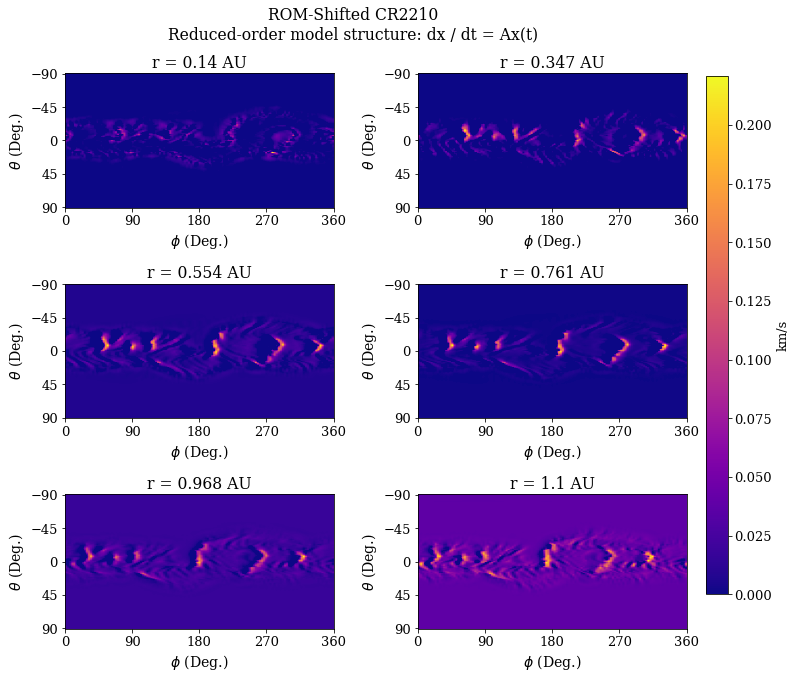

In [49]:
plot_slices_fig((V_ROM-V)/(V), title="ROM-Shifted CR" + cr + "\n" + str(model), figsave="figs/CR" + cr + "/A/mhd_2D_relative_error.png", 
               vmin=0, vmax=None)


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

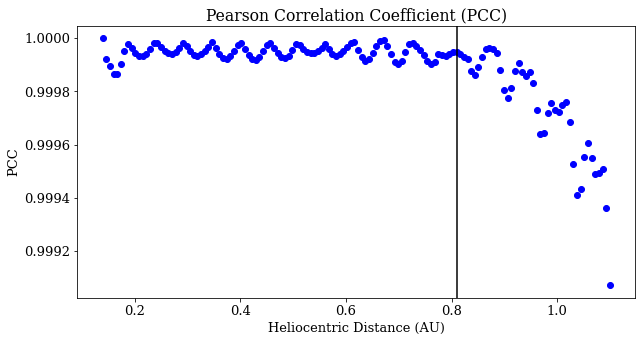

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(np.ndarray.flatten(V[:, :, jj]), np.ndarray.flatten(V_ROM[:, :, jj]))[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")

plt.savefig("figs/CR" + cr + "/A/pcc_shifted_operator_inference_mhd.png")

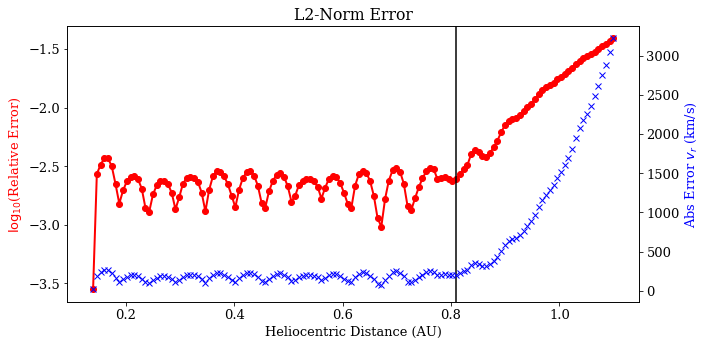

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))

abs_l2err_A, rel_l2err_A = roi.post.lp_error(flatten(V), flatten(V_ROM))

_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2err_A),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2err_A, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

In [52]:
abs_froerr, rel_froerr = roi.post.frobenius_error(flatten(V), flatten(V_ROM))
print(f"Relative error: {rel_froerr:%}")

Relative error: 1.060483%


In [53]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.005550152183292784


### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$ and rank $r$.

In [54]:
coeff_array = 10**np.linspace(1, 6, 20)
rank_array = np.arange(5, 35)

training_error = np.ones((len(coeff_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff_array), len(rank_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    for ii, rank_r in enumerate(rank_array):
        Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank_r) 
        Xdot = roi.pre.xdot(flatten(X_train), (r_train[1] - r_train[0]).value, order=6) 
        model = roi.InferredContinuousROM(modelform="A")            
        model.fit(Vr, flatten(X_train), Xdot, P=coeff)                          
        X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF", 
                              max_step=(r_train[1] - r_train[0]).value) 
        X_ROM = undo_flatten(X_ROM)
        
        if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
            V_ROM = convert_from_x_to_v(X_ROM)
            # save
            training_error[kk, ii] = stats.pearsonr(np.ndarray.flatten(V[:, :, :l]), 
                                                    np.ndarray.flatten(V_ROM[:, :, :l]))[0]
            # save
            testing_error[kk, ii] = stats.pearsonr(np.ndarray.flatten(V[:, :, l:]), 
                                    np.ndarray.flatten(V_ROM[:, :, l:]))[0]

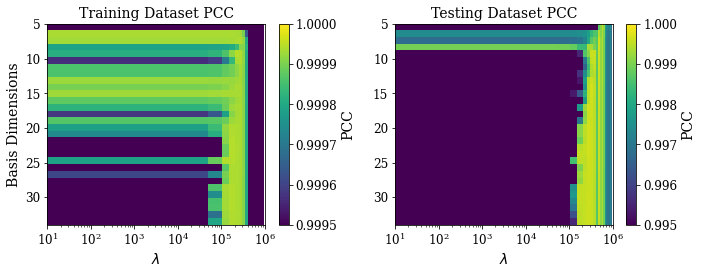

In [55]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

pos1 = ax[0].imshow(training_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], vmin=0.9995, vmax=1, aspect="auto")


_ = ax[0].set_xlabel(r"$\lambda$", fontsize=14)
_ = ax[0].set_ylabel(r"Basis Dimensions", fontsize=14)
_ = ax[0].set_title("Training Dataset PCC", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos1, ax=ax[0])
cbar.ax.set_ylabel('PCC', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

pos2 = ax[1].imshow(testing_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], vmin=0.995, vmax=1, aspect="auto")


_ = ax[1].set_xlabel(r"$\lambda$", fontsize=14)
_ = ax[1].set_title("Testing Dataset PCC", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar = fig.colorbar(pos2, ax=ax[1])
cbar.ax.set_ylabel('PCC', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax[1].set_xscale("log")
ax[0].set_xscale("log")

plt.tight_layout()

In [56]:
idx  = np.unravel_index(training_error.argmax(), training_error.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))
print("Training rank =",  rank_array[idx[1]])

Training lambda = 2.052631578947368
Training rank = 9


In [57]:
idx  = np.unravel_index(testing_error.argmax(), training_error.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array[idx[1]])

Testing lambda = 2.5789473684210527
Testing rank = 14


# Quadratic ROM $\dot{x} = \mathbf{H}(x \otimes x)$

In [58]:
Vr, _ = roi.pre.pod_basis(flatten(X_train), r=9) # Construct the reduced basis.
Xdot = roi.pre.xdot(flatten(X_train), (r_train[1] - r_train[0]).value, order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H") # Define the model structure.
model.fit(Vr, flatten(X_train), Xdot, P=1e7) # Construct the ROM with Operator Inference.
X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.

In [59]:
V_ROM = convert_from_x_to_v(undo_flatten(X_ROM))

In [60]:
V_ROM.shape

(129, 111, 140)

In [61]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.005677322706076154


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_24432/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


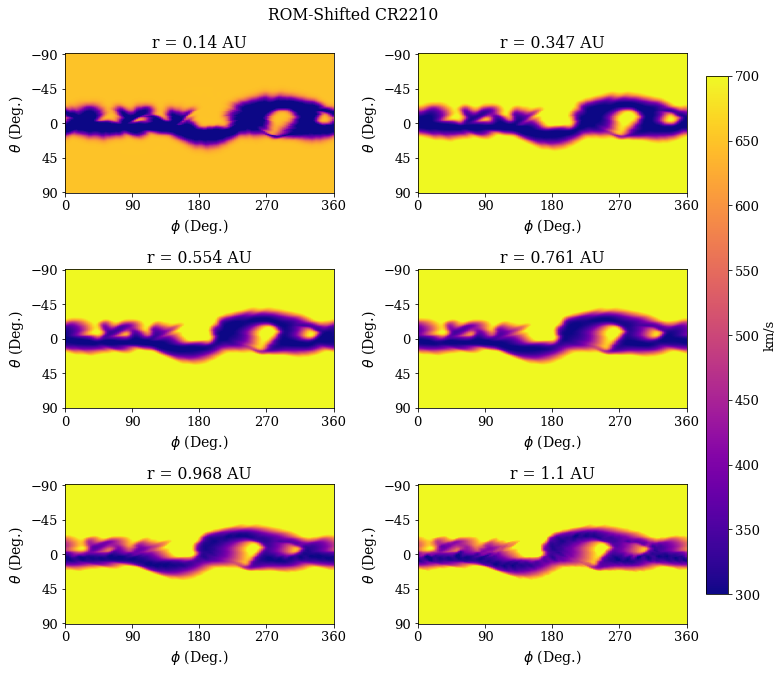

In [62]:
plot_slices_fig(V_ROM, title="ROM-Shifted CR" + cr, figsave="figs/CR" + cr + "/H/mhd_2D_VROM_slices.png")

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_24432/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


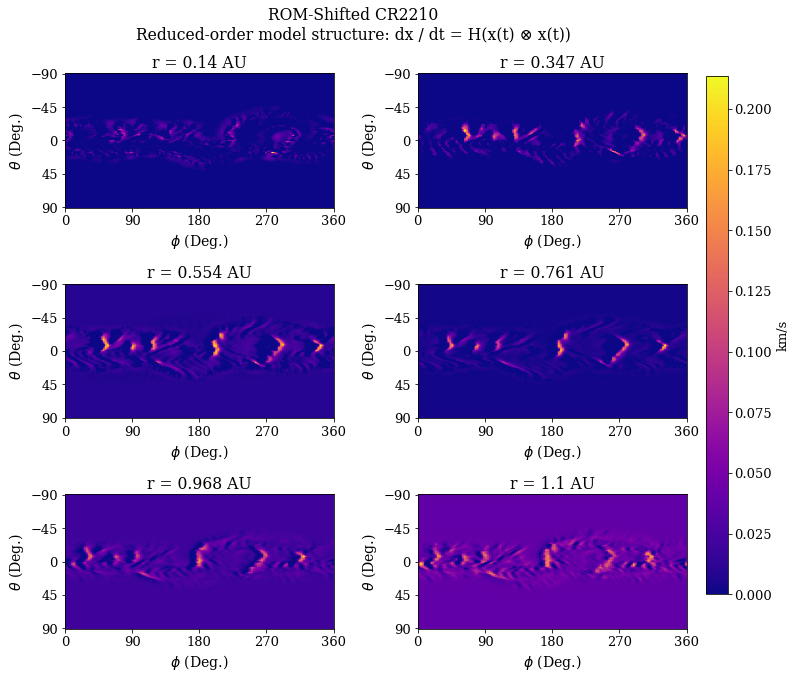

In [63]:
plot_slices_fig((V_ROM-V)/(V), title="ROM-Shifted CR" + cr + "\n" + str(model), figsave="figs/CR" + cr + "/H/mhd_2D_relative_error.png", 
               vmin=0, vmax=None)

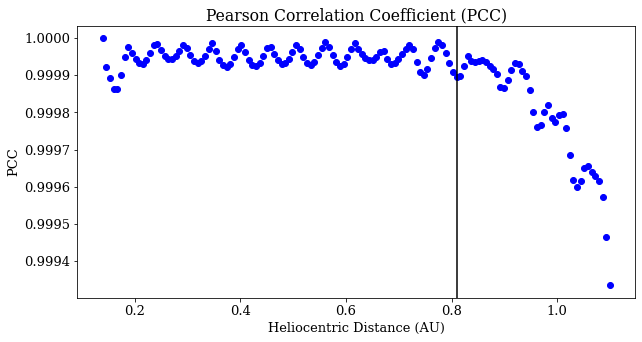

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(np.ndarray.flatten(V[:, :, jj]), np.ndarray.flatten(V_ROM[:, :, jj]))[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")

plt.savefig("figs/CR" + cr + "/H/pcc_shifted_operator_inference_mhd.png")

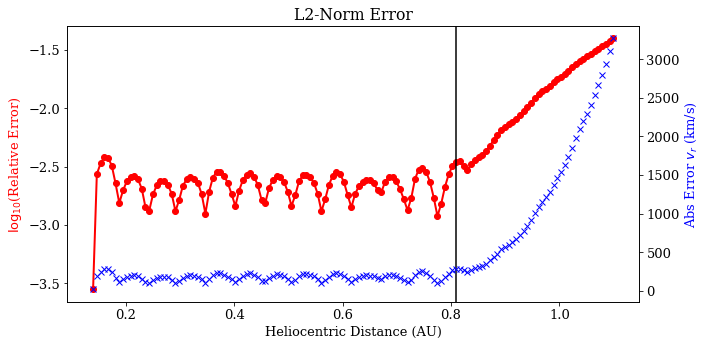

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))

abs_l2err_H, rel_l2err_H = roi.post.lp_error(flatten(V), flatten(V_ROM))

_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2err_H),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2err_H, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

In [66]:
abs_froerr, rel_froerr = roi.post.frobenius_error(flatten(V), flatten(V_ROM))
print(f"Relative error: {rel_froerr:%}")

Relative error: 1.076208%


In [67]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.005677322706076154


In [68]:
coeff_array = 10**np.linspace(6, 10, 20)
rank_array = np.arange(8, 25)

training_error = np.ones((len(coeff_array), len(rank_array))) * np.inf
testing_error = np.ones((len(coeff_array), len(rank_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    for ii, rank_r in enumerate(rank_array):
        Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank_r) 
        Xdot = roi.pre.xdot(flatten(X_train), (r_train[1] - r_train[0]).value, order=6) 
        model = roi.InferredContinuousROM(modelform="H")            
        model.fit(Vr, flatten(X_train), Xdot, P=coeff)                          
        X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF", 
                              max_step=(r_train[1] - r_train[0]).value) 
        X_ROM = undo_flatten(X_ROM)
        
        if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
            V_ROM = convert_from_x_to_v(X_ROM)
            # save
            training_error[kk, ii] = stats.pearsonr(np.ndarray.flatten(V[:, :, :l]), 
                                                    np.ndarray.flatten(V_ROM[:, :, :l]))[0]
            # save
            testing_error[kk, ii] = stats.pearsonr(np.ndarray.flatten(V[:, :, l:]), 
                                    np.ndarray.flatten(V_ROM[:, :, l:]))[0]

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:185: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


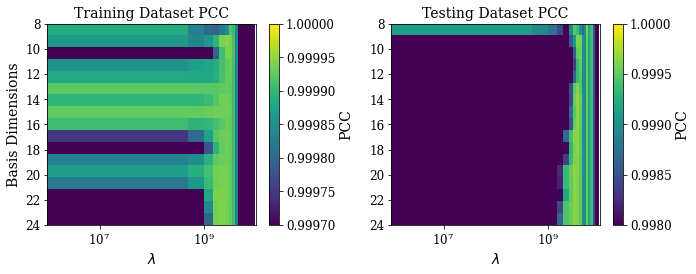

In [69]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

pos1 = ax[0].imshow(training_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], vmin=0.9997, vmax=1, aspect="auto")


_ = ax[0].set_xlabel(r"$\lambda$", fontsize=14)
_ = ax[0].set_ylabel(r"Basis Dimensions", fontsize=14)
_ = ax[0].set_title("Training Dataset PCC", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos1, ax=ax[0])
cbar.ax.set_ylabel('PCC', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

pos2 = ax[1].imshow(testing_error.T, extent=[coeff_array[0], coeff_array[-1], 
                                          rank_array[-1], rank_array[0]], vmin=0.998, vmax=1, aspect="auto")


_ = ax[1].set_xlabel(r"$\lambda$", fontsize=14)
_ = ax[1].set_title("Testing Dataset PCC", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar = fig.colorbar(pos2, ax=ax[1])
cbar.ax.set_ylabel('PCC', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax[1].set_xscale("log")
ax[0].set_xscale("log")

plt.tight_layout()

In [70]:
idx  = np.unravel_index(training_error.argmax(), training_error.shape)
print("Training lambda =",  np.log10(coeff_array[idx[0]]))
print("Training rank =",  rank_array[idx[1]])

Training lambda = 7.052631578947368
Training rank = 9


In [71]:
idx  = np.unravel_index(testing_error.argmax(), testing_error.shape)
print("Testing lambda =",  np.log10(coeff_array[idx[0]]))
print("Testing rank =",  rank_array[idx[1]])

Testing lambda = 7.473684210526316
Testing rank = 14


# Quadradic-Linear ROM  $\frac{d}{dt}\hat{\mathbf{x}}(t) = \hat c + \hat{A}\hat{\mathbf{x}}(t) + \hat{H}\left(\hat{\mathbf{x}}\otimes\hat{\mathbf{x}}\right)(t) $

The optimization problem can be rewriten in the form

$$
    \min_{O\in\mathbb{R}^{r\times d(r,m)}}\left\|DO^{T} - R^{T}\right\|_{F}^2,
$$

where 

$$
O = [\hat A \quad  \hat H]
$$
$$
D = [\hat{\mathbf{x}} \quad  \hat{\mathbf{x}}\otimes\hat{\mathbf{x}}]
$$

$$
R = [\dot{\hat{\mathbf{x}}}]
$$

Then, the regularization constarints enforce that 

$$
    \min_{O}\in\mathbb{R}^{r\times d(r,m)}\left\|DO^{T} - R^{T}\right\|_{F}^2 + \|\Gamma O^{T} \|_{F}^{2},
$$

where the Tikhonov matrix $\Gamma = diag(\lambda_{1} I_{(r)}, \lambda_{2} I_{(r^2)})$ resulting in $L_{2}$ regularization. 

In [54]:
def regularizer(r, λ1, λ2, λ3=None):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    If λ3 is given, the entries of the cubic operator are penalized by λ3.
    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.
    λ2 : float or None
        Regularization hyperparameter for the cubic operator (if present).
    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 = 1 + r
    r2 = r + r*(r + 1)//2
    if λ3 is None:
        diag𝚪 = np.full(r2+1, λ1)
        diag𝚪[r1:-1] = λ2
    else:
        r3 = r2 + r*(r + 1)*(r + 2)//6
        diag𝚪 = np.full(r3+1, λ1)
        diag𝚪[r1:r2] = λ2
        diag𝚪[r2:-1] = λ3
    return diag𝚪

In [58]:
start = time.time()
rank=8
Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank) # Construct the reduced basis.
Xdot = roi.pre.xdot(flatten(X_train), (r_train[1] - r_train[0]).value, order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="cAH") # Define the model structure.
model.fit(Vr, flatten(X_train), Xdot, P=regularizer(rank, 10**8, 10**9)) # Construct the ROM with Operator Inference.
X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
V_ROM = convert_from_x_to_v(undo_flatten(X_ROM))
print("Seconds since epoch =", time.time() - start)

Seconds since epoch = 0.3555030822753906


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_24432/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


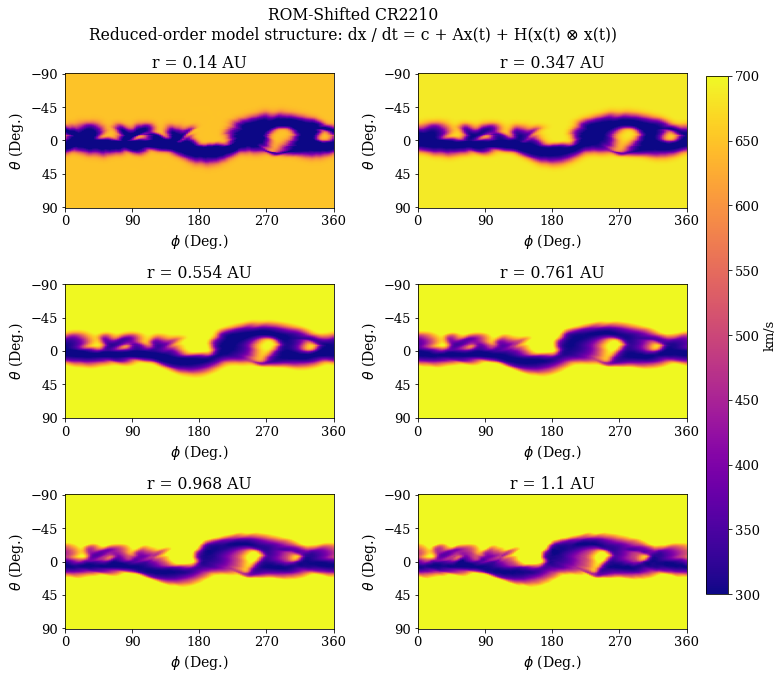

In [75]:
plot_slices_fig(V_ROM, title="ROM-Shifted CR" + cr + "\n" + str(model), 
                figsave="figs/CR" + cr + "/cAH/mhd_2D_VROM_slices.png")

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_24432/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


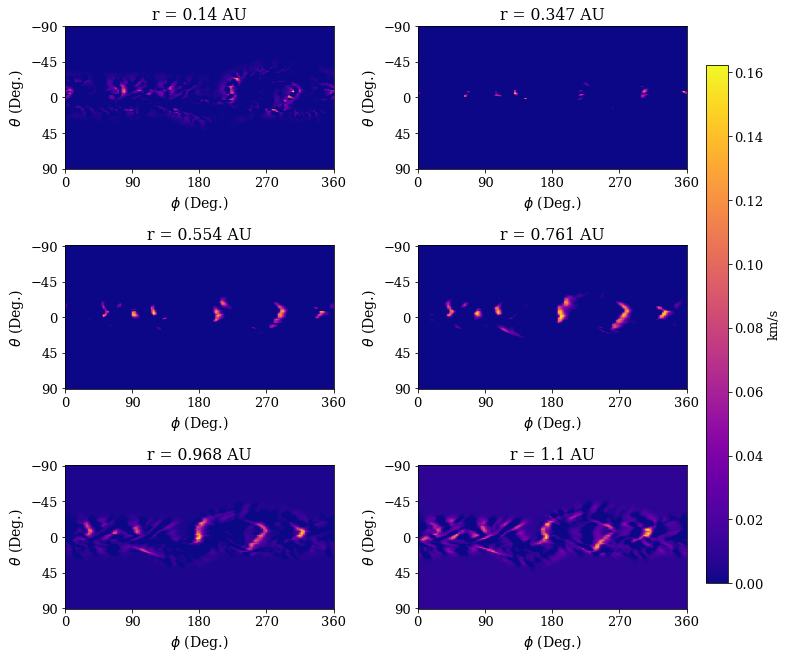

In [76]:
plot_slices_fig((V_ROM-V)/(V), title="", 
               figsave="figs/CR" + cr + "/cAH/mhd_2D_relative_error.png", 
               vmin=0, vmax=None, cbar_label="Relative Error")

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_8750/2379891901.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


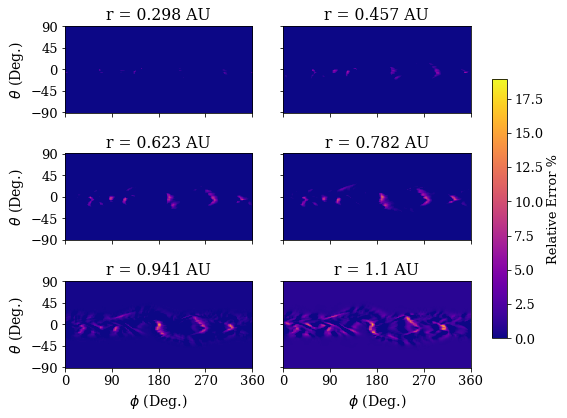

In [62]:
RE = (V_ROM-V)/(V)
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(7,6))

for id_subplot, snapshot in enumerate([1*len(r)//6, 3*len(r)//6,  len(r)-1 - len(r)//6], start=0):
    
    im = ax[id_subplot][0].imshow(100*RE[:, :, snapshot].T,  vmin=0, vmax=np.max(100*RE), 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][0].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
    ax[id_subplot][0].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][0].set_xticks([360, 270, 180, 90, 0])
    
    im = ax[id_subplot][1].imshow(100*RE[:, :, snapshot + len(r)//6].T, vmin=0, vmax=np.max(100*RE), 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][1].set_title("r = " + str(round(r[snapshot + len(r)//6].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][1].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][1].set_xticks([360, 270, 180, 90, 0])

ax[2][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[2][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)

#ax[0][0].set_title("MHD \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")
#ax[0][1].set_title("S-OpInf \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel("Relative Error %", rotation=90)


plt.tight_layout()

fig.savefig("figs/CR" + str(cr) + "/cAH/RE-comparison-cAH.png", dpi=500, bbox_inches='tight')



/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_8750/2905230121.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


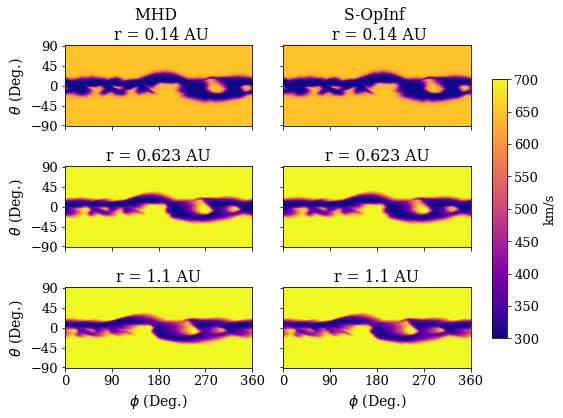

In [60]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(7,6))

for id_subplot, snapshot in enumerate([0, len(r)//2, len(r)-1], start=0):
    im = ax[id_subplot][0].imshow(f[:, :, snapshot].T,  vmin=300, vmax=700, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][0].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
    ax[id_subplot][0].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][0].set_xticks([360, 270, 180, 90, 0])
    
    im = ax[id_subplot][1].imshow(V_ROM[:, :, snapshot].T,  vmin=300, vmax=700, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][1].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][1].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][1].set_xticks([360, 270, 180, 90, 0])

ax[2][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[2][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[0][0].set_title("MHD \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")
ax[0][1].set_title("S-OpInf \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel("km/s", rotation=90)


plt.tight_layout()

fig.savefig("figs/CR" + str(cr) + "/cAH/2D-side-by-side-comparison-cAH.png", dpi=500, bbox_inches='tight')

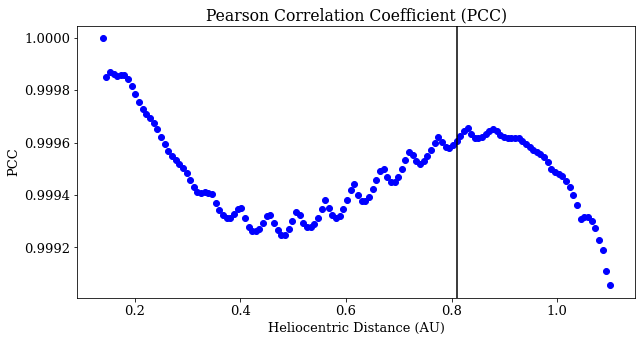

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(np.ndarray.flatten(V[:, :, jj]), np.ndarray.flatten(V_ROM[:, :, jj]))[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")

plt.savefig("figs/CR" + cr + "/cAH/pcc_shifted_operator_inference_mhd.png")

In [80]:
print("PCC Training = ", stats.pearsonr(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM[:, :, :l]))[0])
print("PCC Testing = ", stats.pearsonr(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM[:, :, l:]))[0])

print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :, :l] - V_ROM[:,:,  :l])/np.abs(V[:, :, :l])))
print("Training RE (median) %", 100*np.median(np.abs(V[:, :, :l] - V_ROM[:, :, :l])/np.abs(V[:, :, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :, :l] - V_ROM[:, :, :l])/np.abs(V[:,:, :l])))

print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, :, l:] - V_ROM[:, :, l:])/np.abs(V[:,:, l:])))
print("Testing RE (median) %", 100*np.median(np.abs(V[:, :, l:] - V_ROM[:, :, l:])/np.abs(V[:, :, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, :, l:] - V_ROM[:, :,l:])/np.abs(V[:,:, l:])))

PCC Training =  0.9965567230002927
PCC Testing =  0.999249984835479
Training RE (mean) % 3.5366259524418435
Training RE (median) % 3.6638988074417775
Training RE (max) % 16.36058793334975
Testing RE (mean) % 0.7187439965072313
Testing RE (median) % 0.5431586197444334
Testing RE (max) % 18.913915157942924


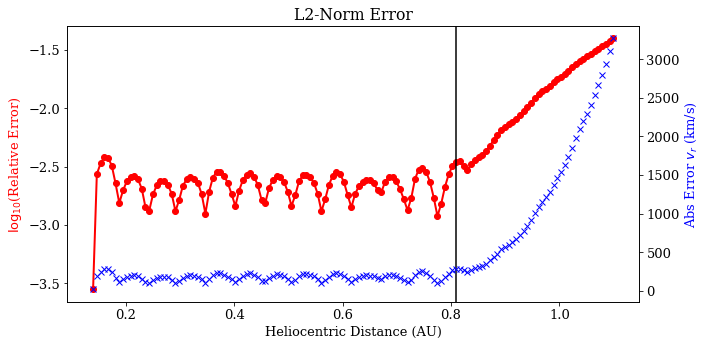

In [81]:
fig, ax = plt.subplots(figsize=(10, 5))

abs_l2err_cAH, rel_l2err_cAH = roi.post.lp_error(flatten(V), flatten(V_ROM))

_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2err_H),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2err_H, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

In [82]:
coeff1_array = 10**np.linspace(6, 10, 10)
coeff2_array = 10**np.linspace(6, 10, 10)
rank_array = np.arange(8, 25, 3)

training_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array))) * -np.inf
testing_error = np.ones((len(coeff1_array),  len(coeff2_array), len(rank_array))) * -np.inf

for kk, coeff1 in enumerate(coeff1_array):
    for jj, coeff2 in enumerate(coeff2_array):
        for ii, rank_r in enumerate(rank_array):
            Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank_r) 
            Xdot = roi.pre.xdot(flatten(X_train), (r_train[1] - r_train[0]).value, order=6) 
            model = roi.InferredContinuousROM(modelform="cAH")            
            model.fit(Vr, flatten(X_train), Xdot, P=regularizer(rank_r, coeff1, coeff2))                          
            X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF", 
                                  max_step=(r_train[1] - r_train[0]).value) 
            X_ROM = undo_flatten(X_ROM)

            if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
                V_ROM = convert_from_x_to_v(X_ROM)
                # save
                training_error[kk, jj, ii] = stats.pearsonr(np.ndarray.flatten(V[:, :, :l]), 
                                                        np.ndarray.flatten(V_ROM[:, :, :l]))[0]
                # save
                testing_error[kk, jj, ii] = stats.pearsonr(np.ndarray.flatten(V[:, :, l:]), 
                                        np.ndarray.flatten(V_ROM[:, :, l:]))[0]

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:398: LinAlgWarning: original least-squares system is underdetermined!
  self._process_

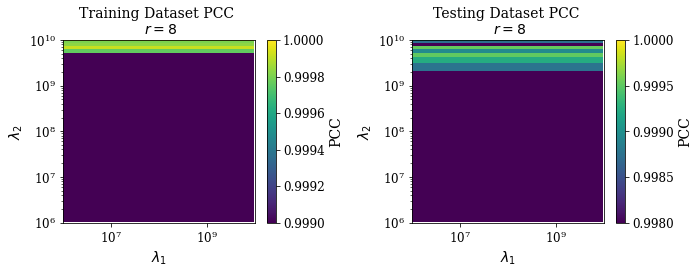

In [83]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

pos1 = ax[0].imshow(training_error[:, :, 0].T, extent=[coeff1_array[0], coeff1_array[-1], 
                                          coeff2_array[0], coeff2_array[-1]], vmin=0.999, vmax=1, aspect="auto")


_ = ax[0].set_xlabel(r"$\lambda_{1}$", fontsize=14)
_ = ax[0].set_ylabel(r"$\lambda_{2}$", fontsize=14)
_ = ax[0].set_title("Training Dataset PCC \n $r = 8$", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos1, ax=ax[0])
cbar.ax.set_ylabel('PCC', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

pos2 = ax[1].imshow(testing_error[:, :, 0].T, extent=[coeff1_array[0], coeff1_array[-1], 
                                          coeff2_array[0], coeff2_array[-1]], vmin=0.998, vmax=1, aspect="auto")


_ = ax[1].set_xlabel(r"$\lambda_{1}$", fontsize=14)
_ = ax[1].set_ylabel(r"$\lambda_{2}$", fontsize=14)
_ = ax[1].set_title("Testing Dataset PCC \n $r = 8$", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar = fig.colorbar(pos2, ax=ax[1])
cbar.ax.set_ylabel('PCC', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax[1].set_xscale("log")
ax[0].set_xscale("log")
ax[1].set_yscale("log")
ax[0].set_yscale("log")

plt.tight_layout()

In [84]:
np.max(training_error[:, :, 0])

0.999917778307639

In [85]:
idx  = np.unravel_index(training_error[:, :, 0].argmax(), training_error[:, :, 0].shape)
print("Training lambda1 =",  np.log10(coeff_array[idx[0]]))
print("Training lambda2 =",  np.log10(coeff_array[idx[1]]))
print("Training rank =",  rank_array[0])

Training lambda1 = 7.894736842105263
Training lambda2 = 6.631578947368421
Training rank = 8


In [86]:
idx  = np.unravel_index(testing_error[:, :, 0].argmax(), testing_error[:, :, 0].shape)
print("Testing lambda1 =",  np.log10(coeff_array[idx[0]]))
print("Testing lambda2 =",  np.log10(coeff_array[idx[1]]))
print("Testing rank =",  rank_array[0])

Testing lambda1 = 6.0
Testing lambda2 = 6.631578947368421
Testing rank = 8


### Comparison of all three models

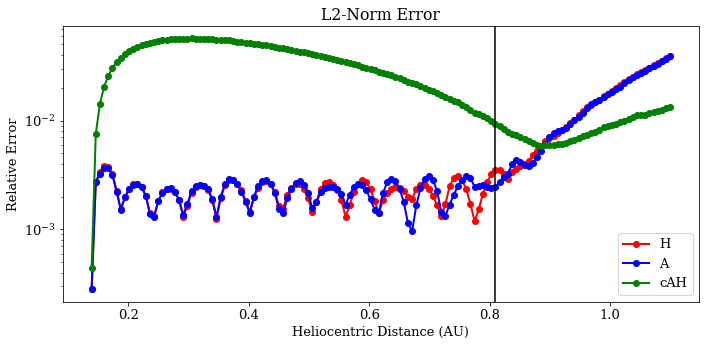

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))


_ = ax.plot(r.to(u.AU).value, rel_l2err_H,"-o", linewidth=2, c="r", label="H")
_ = ax.plot(r.to(u.AU).value, rel_l2err_A,"-o", linewidth=2, c="b", label="A")
_ = ax.plot(r.to(u.AU).value, rel_l2err_cAH,"-o", linewidth=2, c="g", label="cAH")

_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error")
_ = ax.set_ylabel("Relative Error", c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.yscale("log")
plt.tight_layout()
plt.legend()

plt.savefig("figs/CR" + cr +"/comparison_of_models_2d_mhd.png", dpi=300)